# StyleGAN latent space exploration

## Align images

In [3]:
import os
from stylegan2_models.image_aligner.face_alignment import image_align
from stylegan2_models.image_aligner.landmarks_detector import LandmarksDetector
os.chdir("./stylegan2-ada-pytorch")
print(os.getcwd())


/home/artem/work/programming/itmo_deep_gen_models/itmo-deep-gen-models/stylegan2-ada-pytorch


Выравниваем и кадрируем изначальные изображения с лицами актеров

In [4]:


landmarks_model_path = "../stylegan2-ada-pytorch/pretrained_models/shape_predictor_68_face_landmarks.dat"
RAW_IMAGES_DIR = "../celebs"
ALIGNED_IMAGES_DIR = "../aligned_celebs"

landmarks_detector = LandmarksDetector(landmarks_model_path)
for celeb in os.listdir(RAW_IMAGES_DIR):
  celeb_folder = os.path.join(RAW_IMAGES_DIR, celeb)
  save_path = os.path.join(ALIGNED_IMAGES_DIR, celeb)
  os.makedirs(save_path, exist_ok=True)
  for i, img_name in enumerate(os.listdir(celeb_folder)):
      if img_name == ".ipynb_checkpoints":
        continue
      raw_img_path = os.path.join(celeb_folder, img_name)
      for face_landmarks in landmarks_detector.get_landmarks(raw_img_path):
          aligned_face_path = os.path.join(save_path, f"{i}.jpg")
          image_align(raw_img_path, aligned_face_path, face_landmarks)
          break

## StyleGAN face generation

In [4]:
!python3 generate.py --outdir=out --trunc=0.0 --network=pretrained_models/ffhq.pkl --seeds=124

Loading networks from "pretrained_models/ffhq.pkl"...
Generating image for seed 124 (0/1) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


In [5]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# image = ((image * std) + mean)
def plot_image(tensor, plot_size=(10,10)):
  tensor = (tensor.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img = Image.fromarray(tensor[0].cpu().numpy(), 'RGB')
  plt.rcParams["figure.figsize"] = plot_size
  plt.imshow(img)


def plot_images(tensors, plot_size=(10,10)):
  res_tensors = []
  for tensor in tensors:
    tensor = (tensor.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    res_tensors.append(tensor)
  res_tensor = torch.cat(res_tensors, dim=1)
  img = Image.fromarray(res_tensor[0].cpu().numpy(), 'RGB')
  plt.rcParams["figure.figsize"] = plot_size
  plt.imshow(img)


def broadcast_w_sg(w_batch, cast_n=18):
    input_ws = []
    for w in w_batch:
        w_broadcast = torch.broadcast_to(w, (cast_n, 512))
        input_ws.append(w_broadcast)
    return torch.stack(input_ws)


In [6]:
seed = 2345645
noise_mode = 'const' # шум
label = 0 # для разных моделей
device = "cuda:0"
model_path = "./pretrained_models/ffhq.pkl"

with open(model_path, 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()

/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (None)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn(


Setting up PyTorch plugin "bias_act_plugin"... 

Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


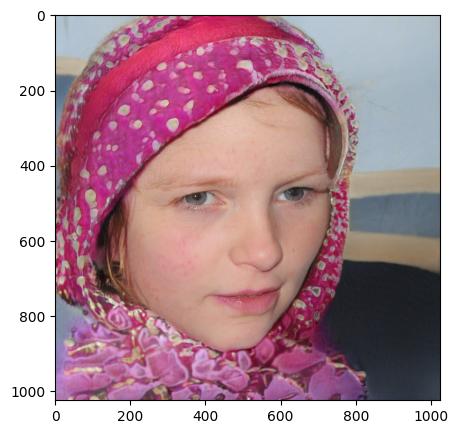

In [7]:
z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)
ws = G.mapping(z, label)

generated_tensor = G.synthesis(ws, noise_mode=noise_mode, force_fp32=True)
plot_image(generated_tensor, (5,5))


## Projection of real images

In [8]:
import PIL
import os
import numpy as np
import torch
import lpips
import torch.nn as nn
import torchvision.transforms as transforms
from pytorch_msssim import ms_ssim
from tqdm import tqdm
import torch.nn.functional as F
from stylegan2_models.e4e.model_utils import load_e4e_standalone
import torchvision.transforms as transforms



# https://pypi.org/project/pytorch-msssim/
class Rec_loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_criterion = torch.nn.L1Loss(reduction='mean')

    def forward(self, target, synth):
        target = torch.add(target, 1.0)
        target = torch.mul(target, 127.5)
        target = target / 255

        synth = torch.add(synth, 1.0)
        synth = torch.mul(synth, 127.5)
        synth = synth / 255

        loss = torch.mean(1 - ms_ssim(synth, target, data_range=1, size_average=True))
        return loss


# https://pypi.org/project/lpips/
class Lpips_loss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.lpips_loss = lpips.LPIPS(net='vgg')
        self.lpips_loss.to(device)
        self.lpips_loss.eval()

    def forward(self, target, synth):
        return torch.mean(self.lpips_loss(target, synth))


# https://github.com/NVlabs/stylegan2-ada-pytorch/blob/main/projector.py#L104
class Reg_loss(nn.Module):
    def __init__(self, noise_bufs):
        super().__init__()
        self.noise_bufs = noise_bufs

    def forward(self,):
        reg_loss = 0.0
        for v in self.noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        return reg_loss

# image = (image - mean) / std
def image2tensor_norm(image):
    transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    tensor = transform(image)
    return tensor

Функция нахождения проекций изображений в пространстве StyleGAN

Сначала находим вектор с помощью модели Encoder4Editing, затем дополнительно улучшаем его с помощью лоссов Lpips_loss, Reg_loss, Rec_loss

В ходе экспериментов я подбирал оптимальные параметры initial_learning_rate, regularize_noise_weight, rec_weight, lpips_weight. Остановился на следующих:

* initial_learning_rate = 0.05,
* regularize_noise_weight = 5e6,
* rec_weight = 0.2,
* lpips_weight = 1.3

In [45]:
def project_image_e4e(image_path, num_steps = 150,
                   initial_learning_rate = 0.05,
                    regularize_noise_weight = 5e6,
                    rec_weight = 0.2,
                    lpips_weight = 1.3,
                    seed = 42):
    e4e_model, _ = load_e4e_standalone("./pretrained_models/e4e_ffhq_encode.pt")

    target_pil = Image.open(image_path).convert('RGB')
    target_tensor = image2tensor_norm(target_pil).to(device).unsqueeze(0)

    image2e4etensor = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((256, 256)),
                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    target_pil = Image.open(image_path).convert('RGB')
    target_uint8 = np.array(target_pil, dtype=np.uint8)

    e4e_tensor = image2e4etensor(target_uint8).to(device).unsqueeze(0)
    initial_latent_vector = e4e_model(e4e_tensor)

    # инициализируем функции потерь
    lpips_loss = Lpips_loss(device)
    rec_loss = Rec_loss()

    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }
    reg_loss = Reg_loss(noise_bufs) 


    initial_latent_vector = nn.Parameter(initial_latent_vector, requires_grad=True)

    optimizer = torch.optim.Adam([initial_latent_vector], lr=initial_learning_rate)
    generated_tensors = []
    for step in tqdm(range(num_steps)):
        synth_tensor = G.synthesis(initial_latent_vector, noise_mode='const')

        lpips_value = lpips_loss(synth_tensor, target_tensor)
        rec_value = rec_loss(synth_tensor, target_tensor)
        reg_value = reg_loss()

        loss = lpips_value*lpips_weight + rec_value*rec_weight + reg_value*regularize_noise_weight
        
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        generated_tensors.append(synth_tensor)
    
    #generated_tensor = G.synthesis(initial_latent_vector, noise_mode='const', force_fp32=True)

    # save_image(generated_tensor, path="./projected_image.png")
    print(loss.item())
    return target_tensor, initial_latent_vector

In [46]:
latent_tensor = project_image_e4e('../aligned_celebs/murphy/0.jpg')[1]

/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ho

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 150/150 [00:17<00:00,  8.69it/s]

1145949.25


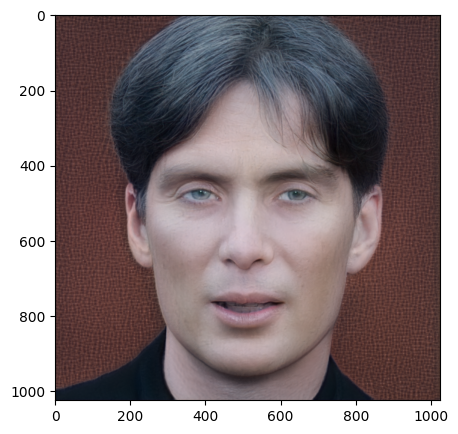

In [47]:
generated_tensor = G.synthesis(latent_tensor, noise_mode='const', force_fp32=True)
plot_image(generated_tensor, (5,5))

Находим проекции всех выбранных актеров

In [48]:
imgs_paths = [
    '../aligned_celebs/mcgregor/0.jpg',
    '../aligned_celebs/murphy/0.jpg',
    '../aligned_celebs/cara/0.jpg',
    '../aligned_celebs/gyl/0.jpg',
    '../aligned_celebs/ivan/0.jpg',
    '../aligned_celebs/nolan/0.jpg'
]

imgs_to_plot = []
celebs_latents = []

for img_path in imgs_paths:
    init_img_tensor, latent_tensor = project_image_e4e(img_path)
    celebs_latents.append(latent_tensor)
    generated_tensor = G.synthesis(latent_tensor, noise_mode='const', force_fp32=True)
    vis_res = torch.cat((init_img_tensor, generated_tensor), dim=3)
    imgs_to_plot.append(vis_res)


/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ho

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 150/150 [00:17<00:00,  8.70it/s]


1145949.125


/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ho

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 150/150 [00:17<00:00,  8.69it/s]


1145949.25


/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ho

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 150/150 [00:17<00:00,  8.68it/s]


1145949.125


/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ho

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 150/150 [00:17<00:00,  8.67it/s]


1145949.25


/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ho

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 150/150 [00:17<00:00,  8.71it/s]


1145949.0


/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ho

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 150/150 [00:16<00:00,  8.86it/s]

1145949.125


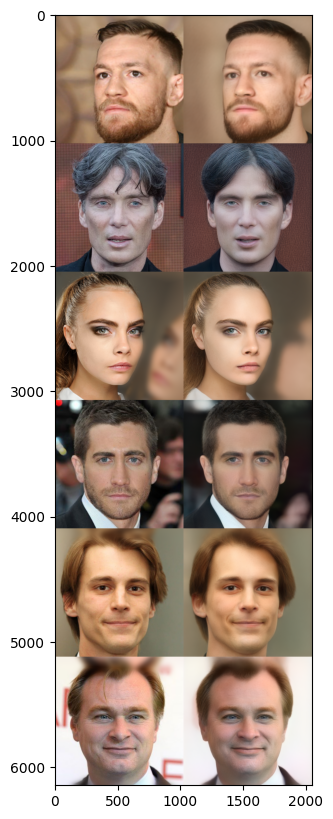

In [49]:
plot_images(imgs_to_plot, (10,10))

Попробуем улучшить качество полученных проекций, добавив CosineAnnealingLR scheduler в train loop

In [56]:
def project_image_e4e(image_path, num_steps = 150,
                   initial_learning_rate = 0.05,
                   min_learning_rate = 0.0001,
                    regularize_noise_weight = 5e6,
                    rec_weight = 0.2,
                    lpips_weight = 1.3,
                    seed = 42):
    e4e_model, _ = load_e4e_standalone("./pretrained_models/e4e_ffhq_encode.pt")

    target_pil = Image.open(image_path).convert('RGB')
    target_tensor = image2tensor_norm(target_pil).to(device).unsqueeze(0)

    image2e4etensor = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((256, 256)),
                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    target_pil = Image.open(image_path).convert('RGB')
    target_uint8 = np.array(target_pil, dtype=np.uint8)

    e4e_tensor = image2e4etensor(target_uint8).to(device).unsqueeze(0)
    initial_latent_vector = e4e_model(e4e_tensor)

    # инициализируем функции потерь
    lpips_loss = Lpips_loss(device)
    rec_loss = Rec_loss()

    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }
    reg_loss = Reg_loss(noise_bufs) 


    
    initial_latent_vector = nn.Parameter(initial_latent_vector, requires_grad=True)

    optimizer = torch.optim.Adam([initial_latent_vector], lr=initial_learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_steps, eta_min=min_learning_rate)
    generated_tensors = []
    for step in tqdm(range(num_steps)):
        synth_tensor = G.synthesis(initial_latent_vector, noise_mode='const')

        lpips_value = lpips_loss(synth_tensor, target_tensor)
        rec_value = rec_loss(synth_tensor, target_tensor)
        reg_value = reg_loss()

        loss = lpips_value*lpips_weight + rec_value*rec_weight + reg_value*regularize_noise_weight

        
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        scheduler.step()
        generated_tensors.append(synth_tensor)
        
    
    print(loss.item())
    return target_tensor, initial_latent_vector

In [57]:
imgs_to_plot = []
celebs_latents = []

for img_path in imgs_paths:
    init_img_tensor, latent_tensor = project_image_e4e(img_path)
    celebs_latents.append(latent_tensor)
    generated_tensor = G.synthesis(latent_tensor, noise_mode='const', force_fp32=True)
    vis_res = torch.cat((init_img_tensor, generated_tensor), dim=3)
    imgs_to_plot.append(vis_res)


/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ho

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 150/150 [00:17<00:00,  8.69it/s]


1145949.125


/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ho

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 150/150 [00:16<00:00,  9.17it/s]


1145949.25


/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ho

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 150/150 [00:16<00:00,  9.01it/s]


1145949.125


/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ho

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 150/150 [00:16<00:00,  9.22it/s]


1145949.25


/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ho

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 150/150 [00:16<00:00,  8.90it/s]


1145949.125


/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ho

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 150/150 [00:16<00:00,  8.89it/s]

1145949.125


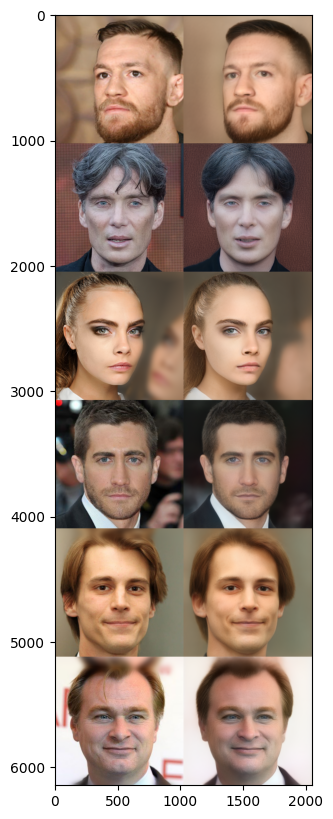

In [58]:
plot_images(imgs_to_plot, (10,10))

Как можно заметить, добавление CosineAnnealingLR scheduler не помогло значительно улучшить качество полученных проекций

## Style transfer

Выровняем выбранные изображения со стилями лиц

In [60]:
raw_img_path = '../styles/cyber.png'
for face_landmarks in landmarks_detector.get_landmarks(raw_img_path):
    aligned_face_path = '../styles/cyber_aligned.jpg'
    image_align(raw_img_path, aligned_face_path, face_landmarks)
    break
raw_img_path = '../styles/paint.jpg'
for face_landmarks in landmarks_detector.get_landmarks(raw_img_path):
    aligned_face_path = '../styles/paint_aligned.jpg'
    image_align(raw_img_path, aligned_face_path, face_landmarks)
    break
raw_img_path = '../styles/malevich.png'
for face_landmarks in landmarks_detector.get_landmarks(raw_img_path):
    aligned_face_path = '../styles/malevich_aligned.jpg'
    image_align(raw_img_path, aligned_face_path, face_landmarks)
    break

Найдем проекцию стиля в латентном пространстве

/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ho

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 150/150 [00:17<00:00,  8.81it/s]


1145949.375


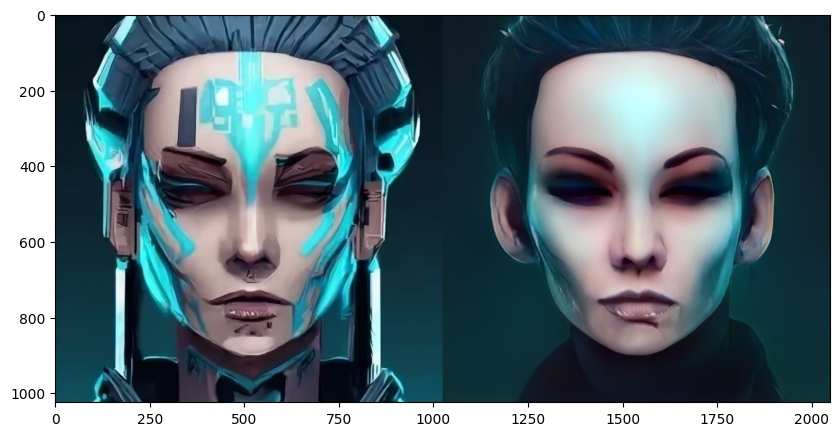

In [61]:
init_img_tensor, style_latent = project_image_e4e('../styles/cyber_aligned.jpg')
generated_tensor = G.synthesis(style_latent, noise_mode='const', force_fp32=True)
vis_res = torch.cat((init_img_tensor, generated_tensor), dim=3)
plot_image(vis_res, (10,10))

Применим Styles crossover для добавления стилей к лицам актеров

In [62]:
def styles_crossover(latent1, latent2, swap_dim_idxs=list(range(6))):
    latent1 = latent1.clone()
    for i in swap_dim_idxs:
        latent1[:, i] = latent2[:, i]
    return latent1

In [63]:

imgs_to_plot = []

for celeb_latent in celebs_latents:
    styled_latent = styles_crossover(celeb_latent, style_latent, list(range(10, 18)))
    styled_tensor = G.synthesis(styled_latent, noise_mode='const', force_fp32=True)
    generated_tensor = G.synthesis(celeb_latent, noise_mode='const', force_fp32=True)
    vis_res = torch.cat((generated_tensor, styled_tensor), dim=3)
    imgs_to_plot.append(vis_res)


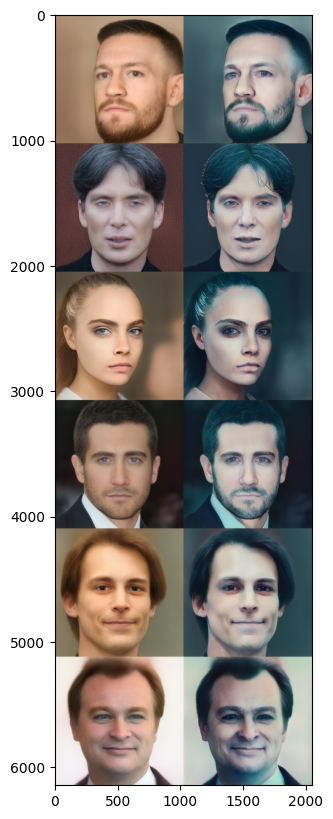

In [64]:
plot_images(imgs_to_plot, (10,10))

В ходе экспериментов остановился на замене векторов с индексами [10, 18). Как можно заметить, стиль применился хорошо, поскольку основные черты лица не поменялись, а цвет, свет и текстура изменились

/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ho

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 150/150 [00:17<00:00,  8.69it/s]


1145949.375


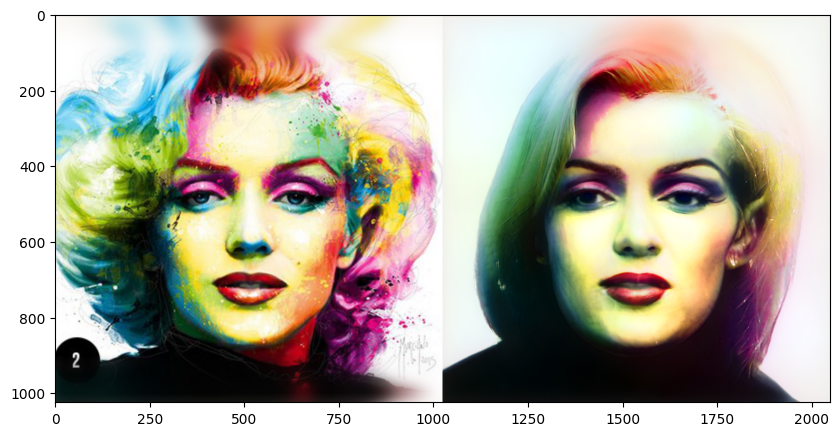

In [65]:

init_img_tensor, style_latent = project_image_e4e('../styles/paint_aligned.jpg')
generated_tensor = G.synthesis(style_latent, noise_mode='const', force_fp32=True)
vis_res = torch.cat((init_img_tensor, generated_tensor), dim=3)
plot_image(vis_res, (10,10))


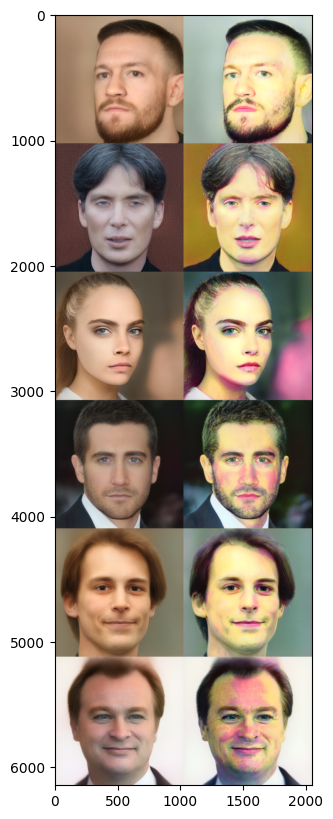

In [88]:
imgs_to_plot = []
indeces = [11,12,13,14,15,16,17]
for celeb_latent in celebs_latents:
    # styled_latent = styles_crossover(celeb_latent, style_latent, list(range(8, 18)))
    styled_latent = styles_crossover(celeb_latent, style_latent, indeces)
    styled_tensor = G.synthesis(styled_latent, noise_mode='const', force_fp32=True)
    generated_tensor = G.synthesis(celeb_latent, noise_mode='const', force_fp32=True)
    vis_res = torch.cat((generated_tensor, styled_tensor), dim=3)
    imgs_to_plot.append(vis_res)


plot_images(imgs_to_plot, (10,10))

/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ho

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/artem/anaconda3/envs/itmo_cv_project/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 150/150 [00:17<00:00,  8.80it/s]


1145949.375


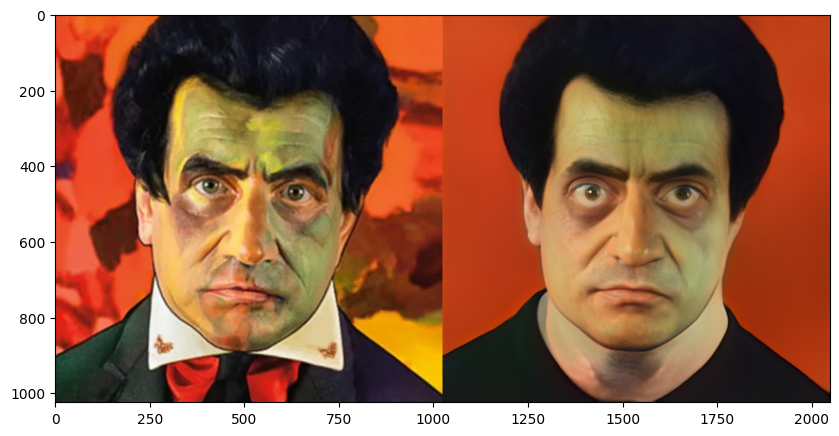

In [89]:

init_img_tensor, style_latent = project_image_e4e('../styles/malevich_aligned.jpg')
generated_tensor = G.synthesis(style_latent, noise_mode='const', force_fp32=True)
vis_res = torch.cat((init_img_tensor, generated_tensor), dim=3)
plot_image(vis_res, (10,10))


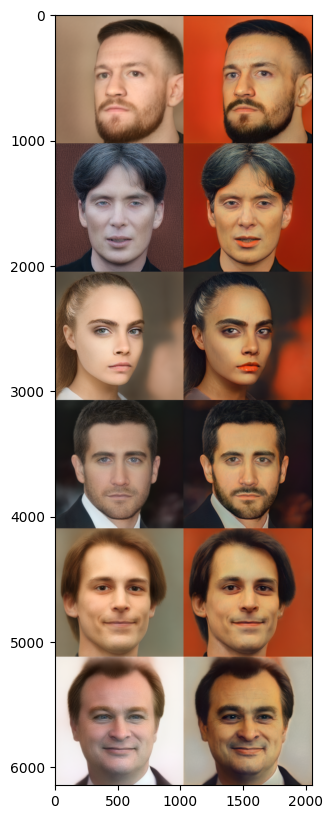

In [98]:
imgs_to_plot = []
indeces = [10,11,12,13,14,15,16,17]
for celeb_latent in celebs_latents:
    #styled_latent = styles_crossover(celeb_latent, style_latent, list(range(10, 18)))
    styled_latent = styles_crossover(celeb_latent, style_latent, indeces)
    styled_tensor = G.synthesis(styled_latent, noise_mode='const', force_fp32=True)
    generated_tensor = G.synthesis(celeb_latent, noise_mode='const', force_fp32=True)
    vis_res = torch.cat((generated_tensor, styled_tensor), dim=3)
    imgs_to_plot.append(vis_res)


plot_images(imgs_to_plot, (10,10))

## Interpolation and editing

Попробуем отредактировать изображения с помощью интерполяции

In [101]:

def interpolate(latent1, latent2, psi=0.5, indeces=[i for i in range(0,18)]):
    init_latent = latent1.clone()
    latent1 = latent1.clone()
    latent2 = latent2.clone()
    for i in indeces:
        latent1[:, i] = latent2[:, i].lerp(latent1[:, i], psi)

    edited_tensor = G.synthesis(latent1, noise_mode='const', force_fp32=True)
    init_tensor = G.synthesis(init_latent, noise_mode='const', force_fp32=True)
    return init_tensor, edited_tensor




In [102]:
expressions_paths = [
    '../stylegan2_pretrained_models/editing/editing/age.pt',
    '../stylegan2_pretrained_models/editing/editing/pose.pt',
    '../stylegan2_pretrained_models/editing/editing/smile.pt'
]

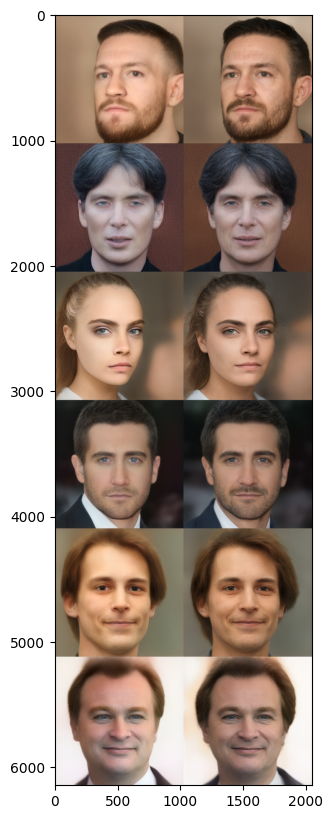

In [116]:
# age
expr_latent=torch.load(expressions_paths[0]).to(device) 
expr_latent = broadcast_w_sg(expr_latent)

#indeces = [0,1,2,3,4,5,6]
indeces = [i for i in range(2,18)]

imgs_to_plot = []
for celeb_latent in celebs_latents:
    
    init_tensor, edited_tensor = interpolate(celeb_latent, expr_latent, psi=0.5, indeces=indeces)
    vis_res = torch.cat((init_tensor, edited_tensor), dim=3)
    imgs_to_plot.append(vis_res)


plot_images(imgs_to_plot, (10,10))

В ходе экспериментов остановился на замене векторов с индексами [2,18) и коэффициентом psi=0.5. Как можно заметить, основные черты лица не поменялись, но на некоторых лицах появились морщины и складки (Килиан Мерфи и Кристофер Нолан)

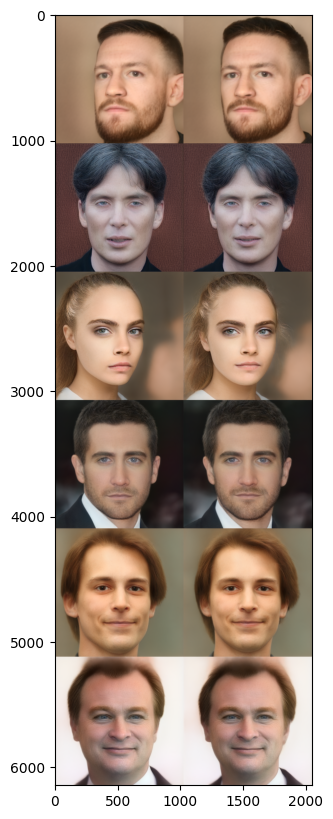

In [138]:
# pose
expr_latent=torch.load(expressions_paths[1]).to(device) 
expr_latent = broadcast_w_sg(expr_latent)

#indeces = [0,1,2,3,4,5,6]
indeces = [i for i in range(0,6)]

imgs_to_plot = []
for celeb_latent in celebs_latents:
    
    init_tensor, edited_tensor = interpolate(celeb_latent, expr_latent, psi=0.6, indeces=indeces)
    vis_res = torch.cat((init_tensor, edited_tensor), dim=3)
    imgs_to_plot.append(vis_res)


plot_images(imgs_to_plot, (10,10))

Как можно заметить, положение некоторых лиц поменялось, немного центрировалось

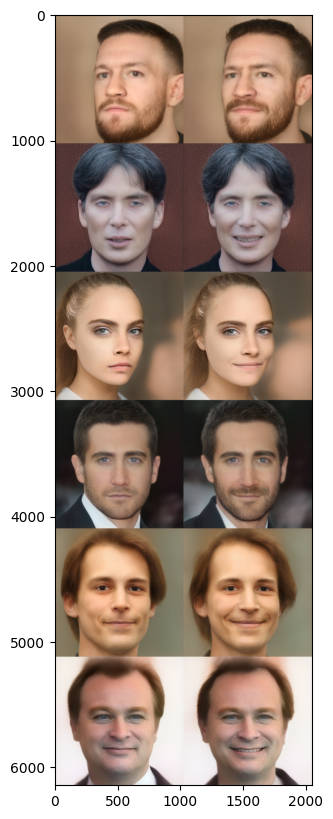

In [156]:
# smile
expr_latent=torch.load(expressions_paths[2]).to(device) 
expr_latent = broadcast_w_sg(expr_latent)

indeces = [4,5]
#indeces = [i for i in range(0, 6)]

imgs_to_plot = []
for celeb_latent in celebs_latents:
    
    init_tensor, edited_tensor = interpolate(celeb_latent, expr_latent, psi=0.3, indeces=indeces)
    vis_res = torch.cat((init_tensor, edited_tensor), dim=3)
    imgs_to_plot.append(vis_res)


plot_images(imgs_to_plot, (10,10))

Применение улыбки заметно достаточно сильно

# Homework

In [ ]:
# TODO

In [ ]:
file_id = '1QIPdkYyIwqEUS8jBNouWo9eYzr3DwDd5' # URL id.
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('ms1mv3_arcface_r50_fp16.pth')


In [ ]:
import PIL
import os
import numpy as np
import torch
import lpips
import torch.nn as nn
import torchvision.transforms as transforms
from pytorch_msssim import ms_ssim
from stylegan2_models.arcface_model import get_model
import torch.nn.functional as F
from stylegan2_models.e4e.model_utils import load_e4e_standalone
import torchvision.transforms as transforms


def image2tensor_norm(image):
    transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    tensor = transform(image)
    return tensor



class Arcface_Loss(nn.Module):
    def __init__(self, weights_path, device):
        super().__init__()

        self.arcnet = get_model("r50", fp16=False)
        self.arcnet.load_state_dict(torch.load(weights_path))
        self.arcnet.eval()
        self.arcnet.to(device)

        self.cosin_loss = nn.CosineSimilarity(dim=1, eps=1e-6)

    def forward(self, source, synth):

        source = F.interpolate(source,size=(112,112), mode='bicubic')
        synth = F.interpolate(synth,size=(112,112), mode='bicubic')

        emb1 = self.arcnet(source)
        emb2 = self.arcnet(synth)
        loss = (1 - self.cosin_loss(emb1, emb2))[0]
        return loss

# https://drive.google.com/file/d/1QIPdkYyIwqEUS8jBNouWo9eYzr3DwDd5/view?usp=sharing ссылка на загрузку весов
arcface_path = "/content/stylegan2-ada-pytorch/ms1mv3_arcface_r50_fp16.pth"
attr_path  = "/content/aligned_images/Stethem/0.jpg"
id_path = "/content/aligned_images/AJoly/0.jpg"


"""
  1 Взять 6 фотографии, наборе должны быть хотя бы 2 фото с разным поворотом головы
   - Делаем style transfer
   - Замена лиц с новым Arcface лоссом

  2. Expression Transfer


   # * заменить на полный кадр
  # https://github.com/zllrunning/face-parsing.PyTorch
"""
